<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560 entries, 0 to 4559
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        4560 non-null   object
 1   label       4560 non-null   int64 
 2   label_name  4560 non-null   object
dtypes: int64(1), object(2)
memory usage: 107.0+ KB


,text,label,label_name
0,The Organization of the Petroleum Exporting Co...,0,Business
1,American business tycoon Malcolm Glazer has in...,2,Sports
2,NEW YORK (Reuters) - International Business Ma...,1,SciTech
3,"Unilever, the world #39;s largest maker of foo...",0,Business
4,Australia #39;s Nathan Baggaley was over the m...,2,Sports


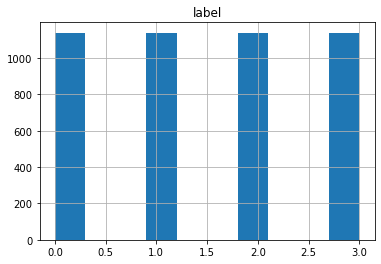

In [1]:
import pandas as pd

df_train = pd.read_json("../data/news_train.json", orient='records')
df_train.info()
df_train.hist()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        1520 non-null   object
 1   label       1520 non-null   int64 
 2   label_name  1520 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.8+ KB


,text,label,label_name
0,While rivals scramble to catch up on the deskt...,1,SciTech
1,AP - UCLA soccer coach Jillian Ellis was happy...,2,Sports
2,PCI Express allows Nvidia to tap into system m...,1,SciTech
3,AP - The Federal Election Commission on Thursd...,3,World
4,City officials hope there are people willing t...,1,SciTech


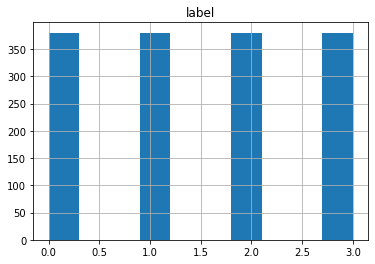

In [2]:
df_test = pd.read_json("../data/news_test.json", orient='records')
df_test.info()
df_test.hist()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        1520 non-null   object
 1   label       1520 non-null   int64 
 2   label_name  1520 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.8+ KB


,text,label,label_name
0,The first hearing in the re-trial of former le...,3,World
1,Intel #39;s board has given the go ahead for t...,0,Business
2,Stocks closed higher on Wall Street as investo...,0,Business
3,Even with a boost from higher oil prices and g...,0,Business
4,Vornado Realty Trust said on Friday it has acq...,0,Business


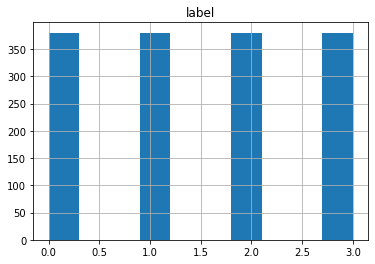

In [3]:
df_val = pd.read_json("../data/news_val.json", orient='records')
df_val.info()
df_val.hist()
df_val.head()

In [4]:
train = list(df_train["text"].values)
val = list(df_val["text"].values)
test = list(df_test["text"].values)

In [5]:
import numpy as np
from tokenizers import BertWordPieceTokenizer

tokenizer = BertWordPieceTokenizer("../data/bert-base-uncased-vocab.txt",
                                   lowercase=True)

def bert_tokenizer(data):
    result = []
    for item in data:
        result.append(tokenizer.encode(item).ids)
    
    return np.array(result, dtype=object)

In [6]:
import tensorflow as tf

maxlen = 128

X_train = bert_tokenizer(train)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
y_train = df_train["label"].values

X_val = bert_tokenizer(val)
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, maxlen=maxlen)
y_val = df_val["label"].values


X_test = bert_tokenizer(test)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
y_test = df_test["label"].values

In [7]:
import tensorflow as tf

emb_size = 32
max_features = 30523 # vocab size

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, emb_size, input_length=maxlen),
    tf.keras.layers.Conv1D(32, 7, activation='relu'),
    tf.keras.layers.MaxPooling1D(5),
    tf.keras.layers.Conv1D(32, 7, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(units=4, activation='softmax')
]) 

model_cnn.compile(optimizer='adam',
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 32)           976736    
_________________________________________________________________
conv1d (Conv1D)              (None, 122, 32)           7200      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 24, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 18, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 132       
Total params: 991,268
Trainable params: 991,268
Non-trainable params: 0
__________________________________________________

In [8]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

h_cnn = model_cnn.fit(X_train, 
                      y_train,
                      epochs=5,
                      batch_size=32,
                      callbacks=[callback],
                      validation_data=(X_val, y_val))

Epoch 1/5
143/143 [==============================] - 2s 12ms/step - loss: 1.3761 - accuracy: 0.2840 - val_loss: 1.1130 - val_accuracy: 0.5954
Epoch 2/5
143/143 [==============================] - 1s 8ms/step - loss: 0.7701 - accuracy: 0.7498 - val_loss: 0.4715 - val_accuracy: 0.8368
Epoch 3/5
143/143 [==============================] - 1s 9ms/step - loss: 0.1780 - accuracy: 0.9543 - val_loss: 0.4421 - val_accuracy: 0.8408
Epoch 4/5
143/143 [==============================] - 1s 9ms/step - loss: 0.0439 - accuracy: 0.9917 - val_loss: 0.4881 - val_accuracy: 0.8349
Epoch 5/5
143/143 [==============================] - 1s 8ms/step - loss: 0.0123 - accuracy: 0.9992 - val_loss: 0.5152 - val_accuracy: 0.8322


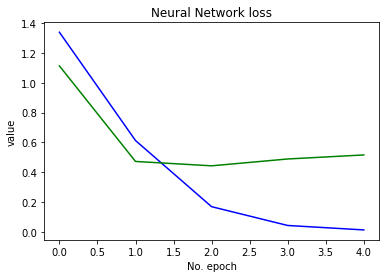

In [9]:
import matplotlib.pyplot as plt

plt.plot(h_cnn.history['loss'], label='(training data)',color='blue')
plt.plot(h_cnn.history['val_loss'], label='(val data)',color='green')
plt.title('Neural Network loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

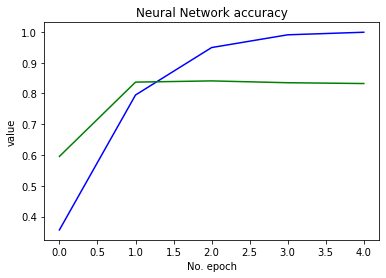

In [10]:
import matplotlib.pyplot as plt

plt.plot(h_cnn.history['accuracy'], label='(training data)',color='blue')
plt.plot(h_cnn.history['val_accuracy'], label='(val data)',color='green')
plt.title('Neural Network accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

In [11]:
results = model_cnn.evaluate(X_test, y_test, batch_size=32)
print("Simple cnn test loss, test acc:", results)

48/48 [==============================] - 0s 2ms/step - loss: 0.5522 - accuracy: 0.8230
Simple cnn test loss, test acc: [0.552157461643219, 0.8230262994766235]


In [12]:
total_len = max([len(item) for item in train])
total_len

830

In [13]:
X_train = bert_tokenizer(train)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=total_len)

X_val = bert_tokenizer(val)
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, maxlen=total_len)

X_test = bert_tokenizer(test)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=total_len)

In [14]:
import tensorflow as tf

emb_size = 32
max_features = 30524 # vocab size

model_cnn_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, emb_size, input_length=total_len),
    tf.keras.layers.Conv1D(32, 7, activation='relu'),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=4, activation='softmax')
]) 

model_cnn_gru.compile(optimizer='adam',
                      loss="sparse_categorical_crossentropy",
                      metrics=['accuracy'])

model_cnn_gru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 830, 32)           976768    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 824, 32)           7200      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 990,436
Trainable params: 990,436
Non-trainable params: 0
_________________________________________________________________


In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

h_cnn_gru = model_cnn_gru.fit(X_train, 
                              y_train,
                              epochs=5,
                              batch_size=32,
                              callbacks=[callback],
                              validation_data=(X_val, y_val))

Epoch 1/5
143/143 [==============================] - 60s 404ms/step - loss: 1.3629 - accuracy: 0.2814 - val_loss: 0.9378 - val_accuracy: 0.5724
Epoch 2/5
143/143 [==============================] - 55s 385ms/step - loss: 0.6610 - accuracy: 0.7599 - val_loss: 0.6833 - val_accuracy: 0.7243
Epoch 3/5
143/143 [==============================] - 55s 386ms/step - loss: 0.2040 - accuracy: 0.9334 - val_loss: 0.7003 - val_accuracy: 0.7566
Epoch 4/5
143/143 [==============================] - 55s 383ms/step - loss: 0.0656 - accuracy: 0.9808 - val_loss: 0.7848 - val_accuracy: 0.7533
Epoch 5/5
143/143 [==============================] - 54s 380ms/step - loss: 0.0240 - accuracy: 0.9945 - val_loss: 0.8930 - val_accuracy: 0.7474


In [16]:
results = model_cnn_gru.evaluate(X_test, y_test, batch_size=32)
print("Simple cnn+gru test loss, test acc:", results)

48/48 [==============================] - 2s 38ms/step - loss: 0.9768 - accuracy: 0.7336
Simple cnn+gru test loss, test acc: [0.9767946004867554, 0.7335526347160339]
